In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import ensemble
from sklearn import tree
%matplotlib inline

In [103]:
pd.set_option('display.max_columns', 300)

In [104]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [105]:
class LabelCountEncoder(object):
    def __init__(self):
        self.count_dict = {}
    
    def fit(self, column):
        # This gives you a dictionary with level as the key and counts as the value
        count = column.value_counts().to_dict()
        # We want to rank the key by its value and use the rank as the new value
        # Your code here
        self.count_dict = dict([(key[0], rank+1) for rank, key in enumerate(sorted(count.items(), key = lambda x: x[1]))])
        
    
    def transform(self, column):
        # If a category only appears in the test set, we will assign the value to zero.
        missing = 0
        # Your code here
        return column.map(lambda x:self.count_dict.get(x, missing))
        
    
    def fit_transform(self, column):
        self.fit(column)
        return self.transform(column)

Current dataset has transformed all features into numeric representations. All the categorical features, used get_dummies turning into numbers and was ordered based on their ocurrances. All the ordinal features, transform their value from larget to small as good to bad. However, there's no normalization of numeric features.

In [106]:
# loading the dataset that has preprocessed before
# cleaned out all the missing value: NA -> None, NA -> 0, categorical -> 0,..., n
train_df = pd.read_csv('./pre_processed_train_data.csv')
test_df = pd.read_csv('./pre_processed_test_data.csv')



y_train = train_df['SalePrice']
#y_train_log = np.log(y_train)
X_train = train_df.drop('SalePrice', axis=1)
X_test = test_df.copy()

del train_df, test_df

#print(X_train.head(3))

In [107]:
label_count_df = X_train.copy()
# print(X_train.columns)

for c in label_count_df.columns:
    if label_count_df[c].dtype == 'object':
        lce = LabelCountEncoder()
        label_count_df[c] = lce.fit_transform(label_count_df[c])
        X_test[c] = lce.transform(X_test[c])
        
#print(label_count_df.head(3))

## Linear Model before Data Transformation

In [108]:
import sklearn.model_selection as ms
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

In [109]:
lm = linear_model.LinearRegression()

simple_LM = lm.fit(label_count_df, y_train)

predictions = simple_LM.predict(X_train)
print(predictions.shape)

lm.score(X_train, y_train)

(1460,)


0.8529112785052386

### - Grid Search on Ridge Regularization Linear Model CV

In [110]:
#stratify_divide = ms.StratifiedKFold(n_splits=5, random_state=0)
grid_param = [{'alpha': np.linspace(75, 82, 1000)}]

ridge_search = GridSearchCV(estimator = linear_model.Ridge(), param_grid=grid_param, \
                           cv=5, return_train_score=True)
ridge_search = ridge_search.fit(label_count_df, y_train)

In [111]:
print(ridge_search.best_score_, ridge_search.best_params_)

0.813294388799916 {'alpha': 79.988988988989}


In [112]:
model_ridge = linear_model.Ridge(alpha = 79.988988988989)
model_ridge = model_ridge.fit(label_count_df, y_train)
coef = pd.Series(model_ridge.coef_, index = label_count_df.columns)
print('Ridge picked '+ str(sum(coef != 0)) + ' variables and eliminated the other ' + \
      str(sum(coef == 0)) + ' variables')

Ridge picked 79 variables and eliminated the other 0 variables


Text(0.5,1,'Coefficients in the Ridge Model')

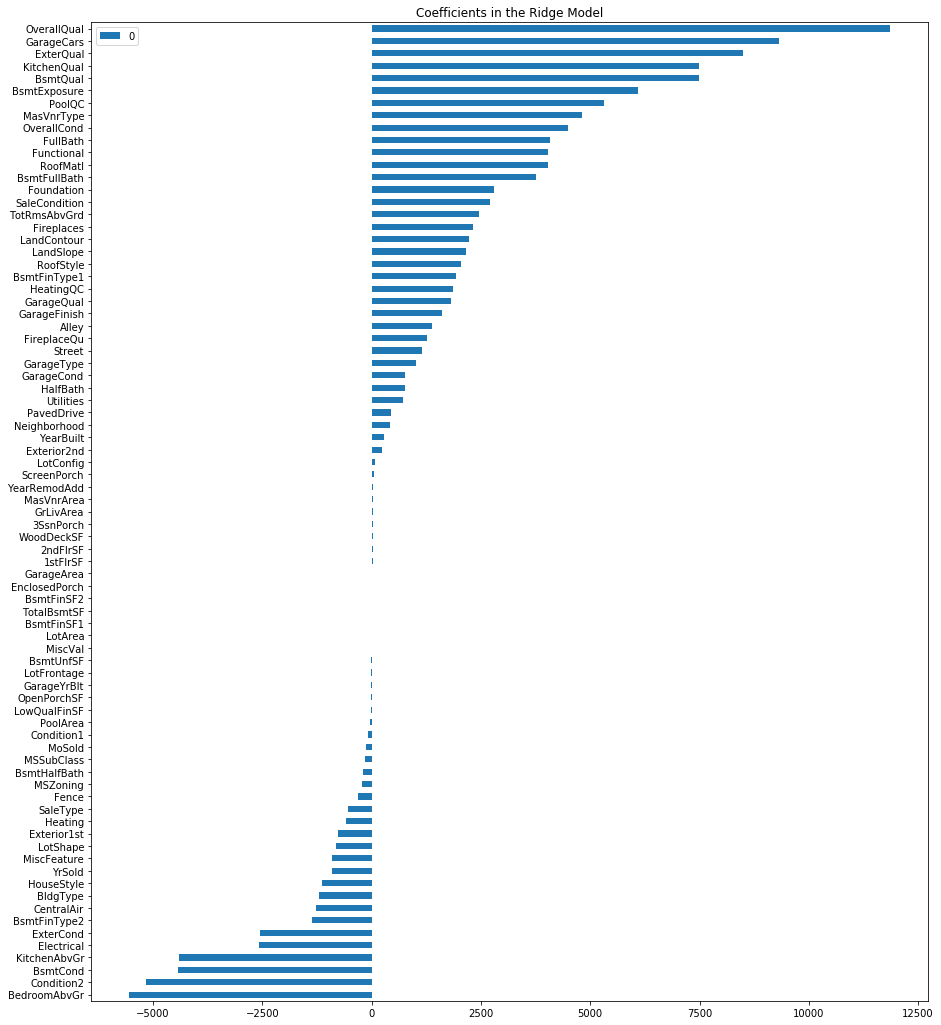

In [113]:
img_coef = pd.DataFrame(coef.sort_values())
img_coef.plot(kind="barh", figsize = (15, 18))
plt.title('Coefficients in the Ridge Model')

### - Grid Search on Lasso Regularization Linear Model CV

In [114]:
grid_param = [{'alpha': np.logspace(2, 5, 1000)}]

lasso_search = GridSearchCV(estimator = linear_model.Lasso(), param_grid = grid_param, \
                           cv = 5, return_train_score = True)
lasso_search = lasso_search.fit(label_count_df, y_train)

In [115]:
print(lasso_search.best_score_, lasso_search.best_params_)

0.8104279580760216 {'alpha': 529.3266058360562}


In [116]:
model_lasso = linear_model.Lasso(alpha = 529.3266058360562)
model_lasso = model_lasso.fit(label_count_df, y_train)
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print('Lasso picked '+ str(sum(coef != 0)) + ' variables and eliminated the other ' + \
      str(sum(coef == 0)) + ' variables')

Lasso picked 56 variables and eliminated the other 23 variables


Text(0.5,1,'Coefficients in the Lasso Model')

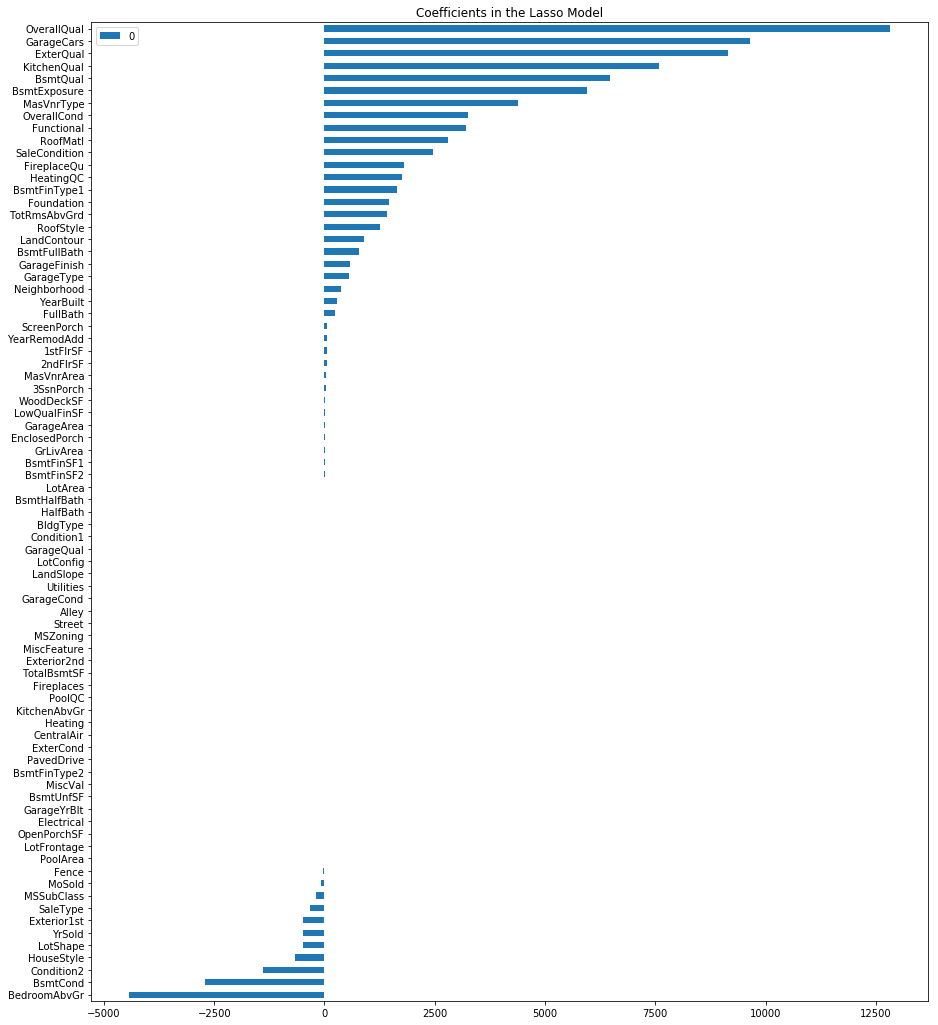

In [117]:
imp_coef = pd.DataFrame(coef.sort_values())
# imp_coef = pd.concat([coef.sort_values().head(30), \
#                       coef.sort_values().tail(12)])
imp_coef.plot(kind = 'barh', figsize = (15, 18))
plt.title('Coefficients in the Lasso Model')

### - Tree Model Test

In [118]:
tree_model = tree.DecisionTreeRegressor()
tree_model.fit(X_train, y_train)

train_error = (1 - tree_model.score(X_train, y_train))
print("The training error is: %.5f" %train_error)


The training error is: 0.00000


In [119]:
tree_model.score(X_train, y_train)

1.0

In [120]:
#print(X_train.columns)

In [121]:
randomforest = ensemble.RandomForestRegressor()
randomforest.set_params(random_state = 42, n_estimators = 50, oob_score=True)
randomforest.fit(X_train, y_train)

print("The training error of random forest is: %.5f" %(1 - randomforest.score(X_train, y_train)))

randomforest.oob_score_

The training error of random forest is: 0.01994


0.860335311483554

#### Some thoughts: 
After the tests of models before data transformation, none of the model shows a good imporvement of accuracy. The skewnes within numeric data leads to parameters lowering themselves to decrease their misleading. Also, the scoring function is not suitable for these non-normal distributed features. Therefore, it is necessary to normalize the data. 